In [1]:
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta

from utils import *
import torch.utils.data as data

from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch

/home/quan1691996/normalization_flow_basis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Create dataset

In [2]:
n_train, n_test = 2000, 1000

train_data, _ = make_moons(n_samples=n_train, noise=0.1)
test_data, _ = make_moons(n_samples=n_test, noise=0.1)

train_loader = data.DataLoader(NumpuDataset(train_data), batch_size=128, shuffle=True)
test_loader = data.DataLoader(NumpuDataset(test_data), batch_size=128, shuffle=True)

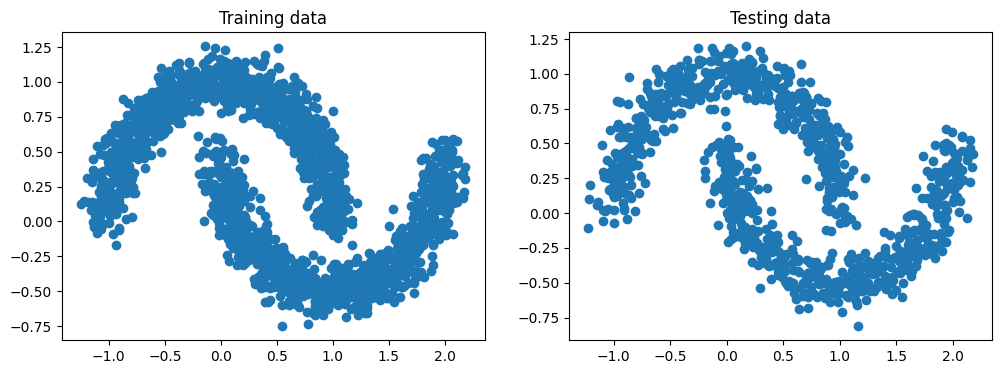

In [3]:
_, axes = plt.subplots(1,2,figsize=(12,4))
x,y = train_loader.dataset.array[:,0], train_loader.dataset.array[:,1]
_ = axes[0].scatter(x,y)
_ = axes[0].set_title('Training data')

x,y = test_loader.dataset.array[:,0], test_loader.dataset.array[:,1]
_ = axes[1].scatter(x,y)
_ = axes[1].set_title('Testing data')

Training

In [24]:
def train_and_eval(epochs, lr, train_loader, test_loader, target_distribution):
    transforms = [AffineTransform2D(True), AffineTransform2D(False), AffineTransform2D(True), AffineTransform2D(False)]
    flow = RealNVP(transforms)
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train(flow, train_loader, optimizer, target_distribution)
        train_losses.append(eval_loss(flow, train_loader, target_distribution))
        test_losses.append(eval_loss(flow, test_loader, target_distribution))
    return flow, train_losses, test_losses

mu = torch.FloatTensor([0.])
sigma = torch.FloatTensor([1.])
target_distribution = Normal(mu, sigma)
flow, train_losses, test_losses = train_and_eval(250, 1e-3, train_loader, test_loader, target_distribution)

View the loss

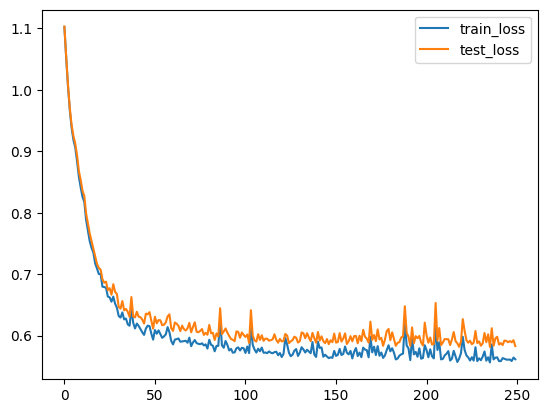

In [25]:
_ = plt.plot(train_losses, label='train_loss')
_ = plt.plot(test_losses, label='test_loss')
_ = plt.legend()

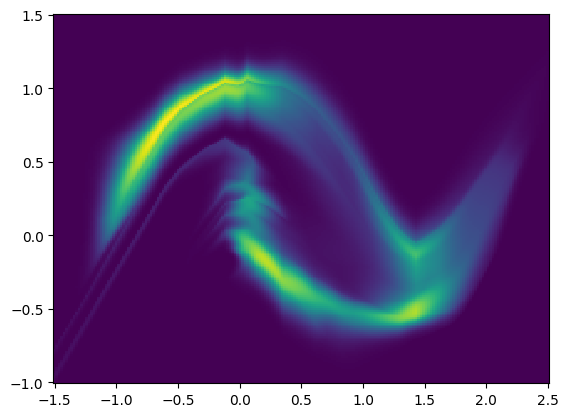

In [26]:
xs = np.linspace(-1.5,2.5,200)
ys = np.linspace(-1,1.5,200)
xs, ys = np.meshgrid(xs, ys)
x = np.stack([xs, ys], axis=2).reshape(-1,2)
with torch.no_grad():
    z, dz_by_dx = flow(torch.FloatTensor(x))
    px = (target_distribution.log_prob(z) + dz_by_dx.log())
    px = px.sum(1).exp()
    px = px.cpu().numpy().reshape(200,200)
    plt.pcolor(xs,ys,px)

Empirical distribution of z

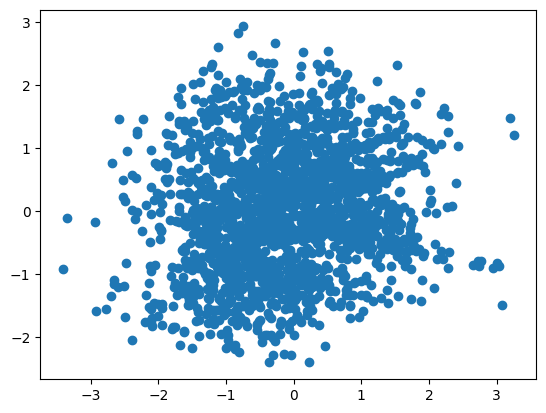

In [15]:
with torch.no_grad():
    z, _ = flow(torch.FloatTensor(train_loader.dataset.array))
    z = z.cpu().numpy()
    plt.scatter(z[:,0], z[:,1])